In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import jinja2
from pycaret.classification import *
from pycaret.utils import check_metric
SEED = 123

In [2]:
# DATA INPUT AND CLEANING
# 123 Columns and 150k rows means that the data needs to be simplified and the non-essentials be stripped.
df = pd.read_csv("2021_LoL_esports_match_data_from_OraclesElixir_20220606.csv")
df_copy = df.copy()
df.shape

(149496, 123)

In [3]:
# Here we can see that there are many incomplete rows, but we can filter to only the rows where the data is "complete".
df.isnull().sum()

gameid                          24
datacompleteness                 0
url                           1512
league                           0
year                             0
split                        49992
playoffs                         0
date                             0
game                             0
patch                            0
participantid                    0
side                             0
position                         0
playername                   24916
playerid                     26126
teamname                        42
teamid                        2160
champion                     24916
ban1                           468
ban2                           330
ban3                           594
ban4                           480
ban5                           750
gamelength                       0
result                           0
kills                            0
deaths                           0
assists                          0
teamkills           

In [4]:
df.dtypes

gameid                       object
datacompleteness             object
url                          object
league                       object
year                          int64
split                        object
playoffs                      int64
date                         object
game                          int64
patch                       float64
participantid                 int64
side                         object
position                     object
playername                   object
playerid                     object
teamname                     object
teamid                       object
champion                     object
ban1                         object
ban2                         object
ban3                         object
ban4                         object
ban5                         object
gamelength                    int64
result                        int64
kills                         int64
deaths                        int64
assists                     

In [5]:
# The real number of unique matches in this dataset.
print("Unique matches in the dataset: {}".format(df["gameid"].nunique()))

Unique matches in the dataset: 12456


In [6]:
# Copy existing dataframe to new dataframe
df_copy = df.copy()

In [7]:
# Filtering for completed data, team data and removing features that are non-team related or deemed useless for our model
df = df[df["datacompleteness"] == "complete"]
df = df[df["position"] == "team"]
df = df.drop_duplicates(subset = "gameid")
col_drop = ["url", "year", "split", "date", "game", "participantid", "playername", "playerid", "teamid", "champion",
            "ban1", "ban2", "ban3", "ban4", "ban5", "kills", "deaths", "assists", "teamkills", "teamdeaths",
            "doublekills", "triplekills", "quadrakills", "pentakills", "firstbloodkill", "firstbloodassist",
            "firstbloodvictim", "team kpm", "ckpm", "dragons", "opp_dragons", "elementaldrakes", "opp_elementaldrakes",
            "infernals", "mountains", "clouds", "oceans", "chemtechs", "hextechs", "dragons (type unknown)",
            "elders", "opp_elders", "heralds", "opp_heralds", "barons", "opp_barons", "towers", "opp_towers",
            "turretplates", "opp_turretplates", "inhibitors", "opp_inhibitors", "damagetochampions", "dpm",
            "damageshare", "damagetakenperminute", "damagemitigatedperminute", "wardsplaced", "wpm", "wardskilled",
            "wcpm", "controlwardsbought", "visionscore", "vspm", "totalgold", "earnedgold", "earned gpm",
            "earnedgoldshare", "goldspent", "gspd", "total cs", "minionkills", "monsterkills", "monsterkillsownjungle",
            "monsterkillsenemyjungle", "cspm", "opp_goldat10", "opp_goldat15", "goldat10", "goldat15", "csat10",
            "csat15", "opp_csat10", "opp_csat15", "xpat10", "xpat15", "opp_xpat10", "opp_xpat15", "league", 
            "opp_assistsat10", "opp_killsat10", "opp_assistsat15", "opp_killsat15", "opp_deathsat10", "opp_deathsat15",
            "gameid", "datacompleteness", "teamname", "side", "position",]        
df.drop(col_drop, inplace=True, axis=1)
df = df.dropna()
df_copy = df.copy()

In [8]:
df_copy.isnull().sum()

playoffs              0
patch                 0
gamelength            0
result                0
firstblood            0
firstdragon           0
firstherald           0
firstbaron            0
firsttower            0
firstmidtower         0
firsttothreetowers    0
golddiffat10          0
xpdiffat10            0
csdiffat10            0
killsat10             0
assistsat10           0
deathsat10            0
golddiffat15          0
xpdiffat15            0
csdiffat15            0
killsat15             0
assistsat15           0
deathsat15            0
dtype: int64

In [9]:
# Now the data is much more concise with no null values.
df.isnull().sum()

playoffs              0
patch                 0
gamelength            0
result                0
firstblood            0
firstdragon           0
firstherald           0
firstbaron            0
firsttower            0
firstmidtower         0
firsttothreetowers    0
golddiffat10          0
xpdiffat10            0
csdiffat10            0
killsat10             0
assistsat10           0
deathsat10            0
golddiffat15          0
xpdiffat15            0
csdiffat15            0
killsat15             0
assistsat15           0
deathsat15            0
dtype: int64

In [10]:
# After data cleaning we are now left with 11,146 games with 23 features.
df.shape

(11148, 23)

<AxesSubplot:>

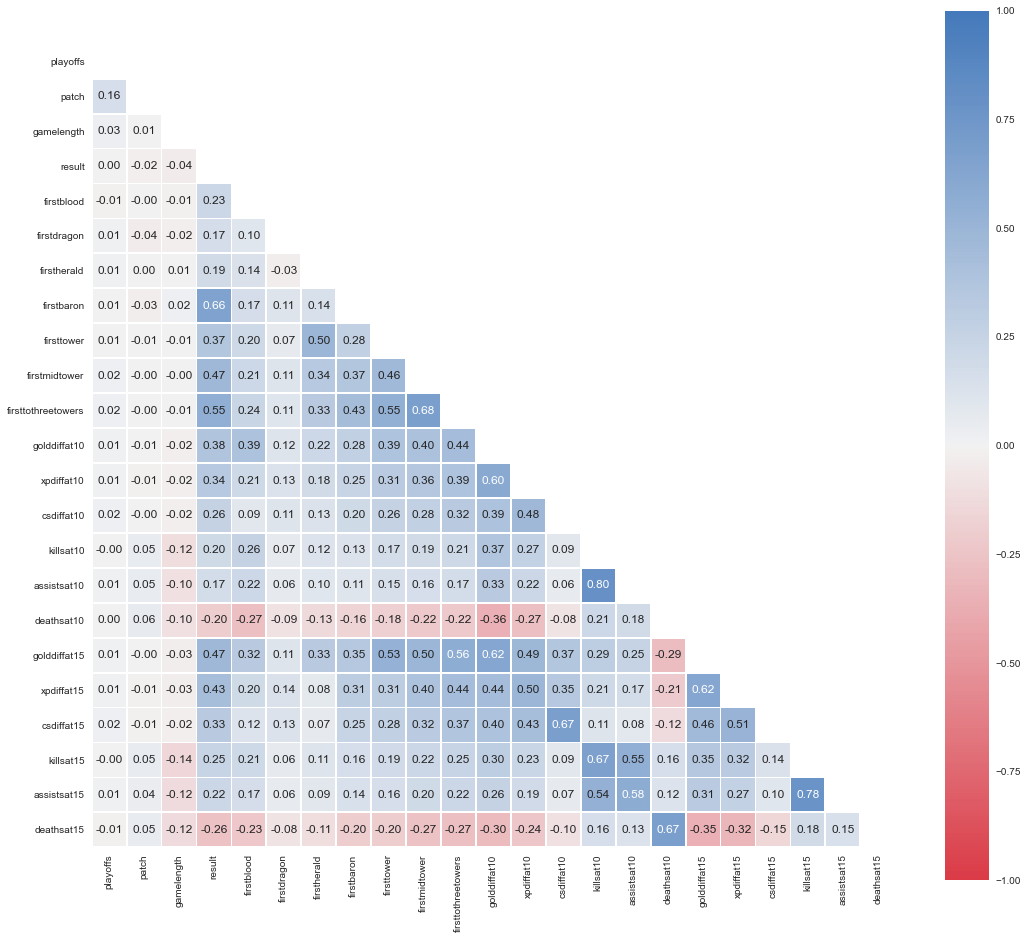

In [11]:
# Correlation of the features is then completed
# If we consider a Correlation of 0.5 or above to be a 'Strong' correlation
plt.figure(figsize=(18, 16))
mask = np.zeros_like(df.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
cmap = sns.diverging_palette(10, 250, as_cmap=True)
sns.heatmap(df.corr(method="kendall"), cmap=cmap, annot=True, fmt='.2f', vmin=-1, vmax=1, 
            mask = mask, square=True, linewidths=.8, center = 0)

In [13]:
df.drop("result", axis=1).columns

Index(['playoffs', 'patch', 'gamelength', 'firstblood', 'firstdragon',
       'firstherald', 'firstbaron', 'firsttower', 'firstmidtower',
       'firsttothreetowers', 'golddiffat10', 'xpdiffat10', 'csdiffat10',
       'killsat10', 'assistsat10', 'deathsat10', 'golddiffat15', 'xpdiffat15',
       'csdiffat15', 'killsat15', 'assistsat15', 'deathsat15'],
      dtype='object')

In [14]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
X_variables = df[['playoffs', 'patch', 'gamelength', 'firstblood', 'firstdragon',
       'firstherald', 'firstbaron', 'firsttower', 'firstmidtower',
       'firsttothreetowers', 'golddiffat10', 'xpdiffat10', 'csdiffat10',
       'killsat10', 'assistsat10', 'deathsat10', 'golddiffat15', 'xpdiffat15',
       'csdiffat15', 'killsat15', 'assistsat15', 'deathsat15']]

In [15]:
vif_data = pd.DataFrame()
vif_data["feature"] = X_variables.columns
vif_data["VIF"] = [variance_inflation_factor(X_variables.values, i) for i in range(len(X_variables.columns))]
vif_data

,feature,VIF
0,playoffs,1.217690
1,patch,12.464378
2,gamelength,1.006723
3,firstblood,2.814385
4,firstdragon,1.876673
5,firstherald,4.543882
6,firstbaron,2.484599
7,firsttower,4.868430
8,firstmidtower,4.583104
9,firsttothreetowers,5.468883


In [16]:
# Reworking and dropping any strongly correlated features
df["KillParat10"] = df["assistsat10"] + df["killsat10"]
df["KillParat15"] = df["assistsat15"] + df["killsat15"]
df = df.drop(df[df.patch == 10.25].index)
df["patch"] = (df["patch"] - 11)*100
round(df["patch"], 1)
df_copy = df.copy()
feature_drop = ["assistsat10", "killsat10", "assistsat15", "killsat15", "golddiffat10", "golddiffat15", 
                "xpdiffat10", "xpdiffat15",]
df = df.drop(feature_drop, axis=1)
df.head()

,playoffs,patch,gamelength,result,firstblood,firstdragon,firstherald,firstbaron,firsttower,firstmidtower,firsttothreetowers,csdiffat10,deathsat10,csdiffat15,deathsat15,KillParat10,KillParat15
46,0,1.0,2050,0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,20.0,0.0,18.0,0.0,2.0,2.0
58,0,1.0,2241,0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,40.0,1.0,44.0,6.0,4.0,11.0
70,0,1.0,1887,0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,-11.0,2.0,-16.0,3.0,5.0,5.0
82,0,1.0,2010,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-12.0,3.0,-17.0,5.0,3.0,4.0
94,0,1.0,2159,0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,-2.0,1.0,-26.0,3.0,5.0,11.0


<AxesSubplot:>

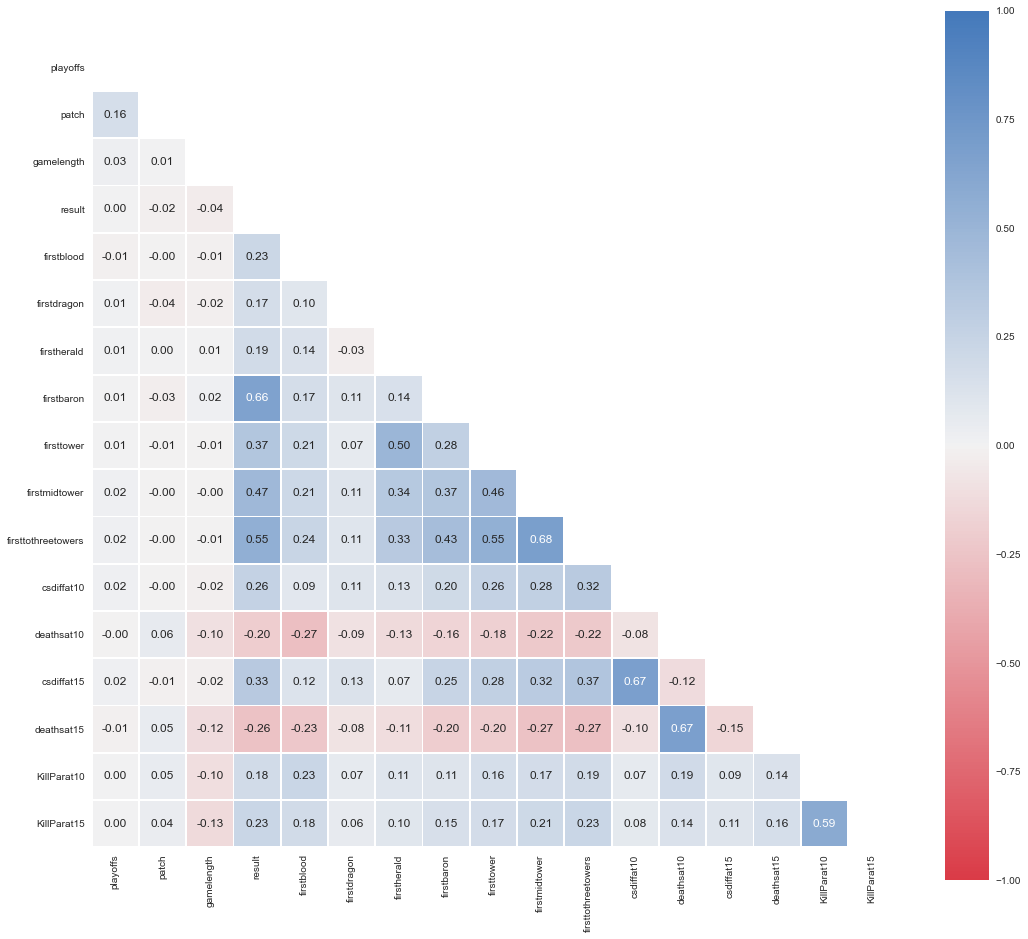

In [17]:
plt.figure(figsize=(18, 16))
mask = np.zeros_like(df.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
cmap = sns.diverging_palette(10, 250, as_cmap=True)
sns.heatmap(df.corr(method="kendall"), cmap=cmap, annot=True, fmt='.2f', vmin=-1, vmax=1, 
            mask = mask, square=True, linewidths=.8, center = 0)

In [18]:
df.columns

Index(['playoffs', 'patch', 'gamelength', 'result', 'firstblood',
       'firstdragon', 'firstherald', 'firstbaron', 'firsttower',
       'firstmidtower', 'firsttothreetowers', 'csdiffat10', 'deathsat10',
       'csdiffat15', 'deathsat15', 'KillParat10', 'KillParat15'],
      dtype='object')

In [19]:
# Descriptive statistics to find if there are any outliers
with pd.option_context('display.max_columns', 15):
    print(df.describe())

           playoffs         patch    gamelength        result    firstblood  \
count  11145.000000  11145.000000  1.114500e+04  11145.000000  11145.000000   
mean       0.174518      8.836608  3.228736e+03      0.526963      0.507761   
std        0.379571      6.060205  5.119096e+04      0.499295      0.499962   
min        0.000000      1.000000  9.110000e+02      0.000000      0.000000   
25%        0.000000      3.000000  1.655000e+03      0.000000      0.000000   
50%        0.000000      7.000000  1.852000e+03      1.000000      1.000000   
75%        0.000000     14.000000  2.079000e+03      1.000000      1.000000   
max        1.000000     24.000000  2.442645e+06      1.000000      1.000000   

        firstdragon   firstherald  ...  firsttothreetowers    csdiffat10  \
count  11145.000000  11145.000000  ...        11145.000000  11145.000000   
mean       0.427725      0.587169  ...            0.545716      0.496007   
std        0.494771      0.492365  ...            0.497928  

In [20]:
# Removing the outliers found in the high end of gamelength
df = df.loc[df["gamelength"] <= np.quantile(df["gamelength"], q=0.99)]
with pd.option_context("display.max_columns", 15):
    print(df.describe())

           playoffs         patch    gamelength        result    firstblood  \
count  11033.000000  11033.000000  11033.000000  11033.000000  11033.000000   
mean       0.173933      8.827789   1872.921871      0.528324      0.507024   
std        0.379069      6.058833    312.655112      0.499220      0.499973   
min        0.000000      1.000000    911.000000      0.000000      0.000000   
25%        0.000000      3.000000   1653.000000      0.000000      0.000000   
50%        0.000000      7.000000   1847.000000      1.000000      1.000000   
75%        0.000000     14.000000   2072.000000      1.000000      1.000000   
max        1.000000     24.000000   2832.000000      1.000000      1.000000   

        firstdragon   firstherald  ...  firsttothreetowers    csdiffat10  \
count  11033.000000  11033.000000  ...        11033.000000  11033.000000   
mean       0.427626      0.586876  ...            0.545636      0.474758   
std        0.494757      0.492417  ...            0.497936  

In [21]:
df.shape

(11033, 17)

In [ ]:
# Normalization
#from sklearn import preprocessing
#scaler = preprocessing.MinMaxScaler()
#names = df.columns
#d = scaler.fit_transform(df)
#scaled_df = pd.DataFrame(d, columns=names)
#df = scaled_df
#df.head

In [22]:
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier
# define dataset
y = df.result
X = df.drop("result", axis=1)
# define RFE
rfe = RFE(estimator=DecisionTreeClassifier(), n_features_to_select=12)
# fit RFE
rfe.fit(X, y)
# summarize all features
for i in range(X.shape[1]):
    print('Column: %d, Selected %s, Rank: %.3f' % (i, rfe.support_[i], rfe.ranking_[i]))

Column: 0, Selected False, Rank: 5.000
Column: 1, Selected True, Rank: 1.000
Column: 2, Selected True, Rank: 1.000
Column: 3, Selected False, Rank: 4.000
Column: 4, Selected True, Rank: 1.000
Column: 5, Selected False, Rank: 2.000
Column: 6, Selected True, Rank: 1.000
Column: 7, Selected False, Rank: 3.000
Column: 8, Selected True, Rank: 1.000
Column: 9, Selected True, Rank: 1.000
Column: 10, Selected True, Rank: 1.000
Column: 11, Selected True, Rank: 1.000
Column: 12, Selected True, Rank: 1.000
Column: 13, Selected True, Rank: 1.000
Column: 14, Selected True, Rank: 1.000
Column: 15, Selected True, Rank: 1.000


Text(0.5, 1.0, 'Correlation Matrix between Features')

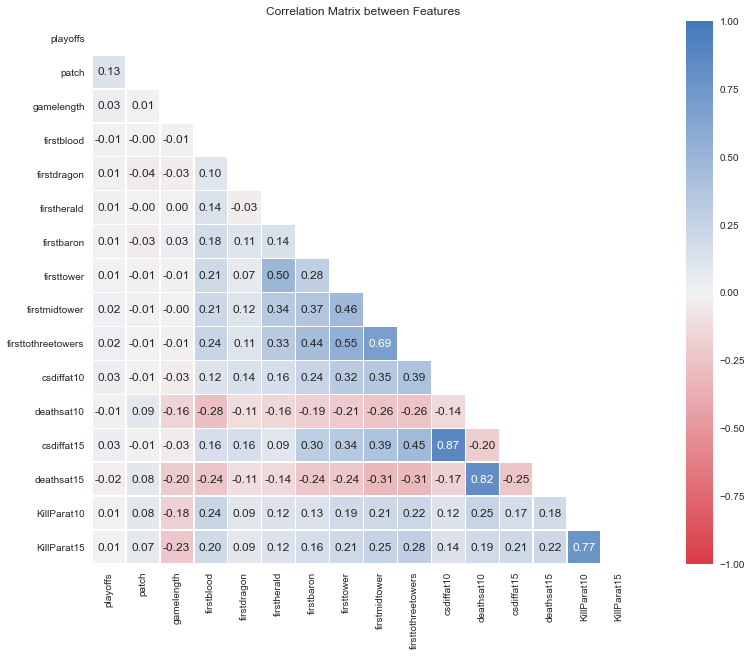

In [23]:
# New correlation matrix with updated feature set
plt.figure(figsize=(18, 10))
mask = np.zeros_like(df.drop("result",axis=1).corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(df.drop("result",axis=1).corr(), cmap=cmap, annot=True, fmt='.2f', vmin=-1, vmax=1, 
            mask = mask, square=True, linewidths=.8, center = 0)
plt.title('Correlation Matrix between Features')

In [24]:
X_variables = df[['playoffs', 'patch', 'gamelength', 'firstblood', 'firstdragon',
       'firstherald', 'firstbaron', 'firsttower', 'firstmidtower',
       'firsttothreetowers', 'csdiffat10',
       'KillParat10', 'deathsat10', 
       'csdiffat15', 'KillParat15', 'deathsat15']]

In [25]:
vif_data = pd.DataFrame()
vif_data["feature"] = X_variables.columns
vif_data["VIF"] = [variance_inflation_factor(X_variables.values, i) for i in range(len(X_variables.columns))]
vif_data

,feature,VIF
0,playoffs,1.235018
1,patch,3.160019
2,gamelength,8.216505
3,firstblood,2.447549
4,firstdragon,1.804742
5,firstherald,3.472183
6,firstbaron,2.493748
7,firsttower,3.944228
8,firstmidtower,4.571757
9,firsttothreetowers,5.380049


In [ ]:
df = pd.DataFrame(data=df)

In [ ]:
#  Split the data into separate 10 and 15 minute datasets
feature_drop2 = ["firstbaron", "firsttothreetowers"]
at10 = []
for column in list(df.columns):
    if '10' in column:
        at10.append(column)
at15 = []
for column in list(df.columns):
    if '15' in column:
        at15.append(column)
df10 = df.drop(at15, axis = 1)
df15 = df.drop(at10, axis = 1)
df20 = df.drop(at10, axis = 1)
df10.drop(feature_drop2, axis = 1, inplace=True)
df15.drop(feature_drop2, axis = 1, inplace=True)

In [ ]:
# Correlation matrix of the 10 minute dataset
plt.figure(figsize=(12, 10))
mask = np.zeros_like(df10.drop("result",axis=1).corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(df10.drop("result",axis=1).corr(), cmap=cmap, annot=True, fmt='.2f', vmin=-1, vmax=1, 
            mask = mask, square=True, linewidths=.8, center = 0)
plt.title('Correlation Matrix between Features (10 minute dataset)')

In [ ]:
# Correlation matrix of the 15 minute dataset
plt.figure(figsize=(12, 10))
mask = np.zeros_like(df15.drop("result",axis=1).corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(df15.drop("result",axis=1).corr(), cmap=cmap, annot=True, fmt='.2f', vmin=-1, vmax=1, 
            mask = mask, square=True, linewidths=.8, center = 0)
plt.title('Correlation Matrix between Features (15 minute dataset)')

In [ ]:
# Correlation matrix of the 20 minute dataset
plt.figure(figsize=(12, 10))
mask = np.zeros_like(df20.drop("result",axis=1).corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(df20.drop("result",axis=1).corr(), cmap=cmap, annot=True, fmt='.2f', vmin=-1, vmax=1, 
            mask = mask, square=True, linewidths=.8, center = 0)
plt.title('Correlation Matrix between Features (20 minute dataset)')

In [ ]:
# Now we check to see if the results are balanced
# Slightly skewed but is fine to use.
print("Blue side win rate: {0:.1f}%".format(df15["result"].sum() / df15["result"].shape[0]*100))
sns.set_style('whitegrid')
fig = sns.countplot(x= df15.result , data=df15, palette= "Blues")
fig.set(xlabel= "Result", ylabel= "Count of Matches", title = "Balance of the dataset")
fig.set_xticklabels(["Loss", "Win"]),

In [ ]:
df15.shape

In [ ]:
df15.hist(alpha = 0.9, figsize=(12,10), bins=20);

In [ ]:
# Baseline Model for 10 minute data
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

y = df10.result
X = df10.drop("result", axis=1)
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=SEED)
rf_model = RandomForestClassifier(random_state=SEED)
rf_model.fit(train_X, train_y)
pred = rf_model.predict(val_X)
score = accuracy_score(val_y, pred)
print('Accuracy: %.2f%%' %(score*100))

# Baseline Accuracy of 74.37% using the Random Forest Algorithm

In [ ]:
# Baseline Model for 15 minute data
y = df15.result
X = df15.drop("result", axis=1)
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=SEED)
rf_model = RandomForestClassifier(random_state=SEED)
rf_model.fit(train_X, train_y)
pred = rf_model.predict(val_X)
score = accuracy_score(val_y, pred)
print('Accuracy: %.2f%%' %(score*100))

# Baseline Accuracy of 76.44% using the Random Forest Algorithm

In [ ]:
# Baseline Model for 20 minute data
y = df20.result
X = df20.drop("result", axis=1)
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=SEED)
rf_model = RandomForestClassifier(random_state=SEED)
rf_model.fit(train_X, train_y)
pred = rf_model.predict(val_X)
score = accuracy_score(val_y, pred)
print('Accuracy: %.2f%%' %(score*100))

# Baseline Accuracy of 84.96% using the Random Forest Algorithm

In [ ]:
# Building a model based on data from the 10 minute mark
#dropped = ["playoffs", "gamelength", "patch"]
#.drop(dropped, axis=1)
models=setup(data=df10,
             target="result",
             silent=True,
             session_id=33,
            normalize=True,
            normalize_method="minmax")

In [ ]:
# Comparing the different model's final results
model_results=compare_models()
model_results

In [ ]:
lr_model=create_model('lr')

In [ ]:
lr_tunedmodel=tune_model(lr_model)

In [ ]:
plot_model(lr_tunedmodel, plot = 'auc')

In [ ]:
plot_model(lr_tunedmodel, plot = 'pr')

In [ ]:
plot_model(lr_tunedmodel, plot='feature')

In [ ]:
plot_model(lr_tunedmodel, plot = 'confusion_matrix')

In [ ]:
predict_model(lr_tunedmodel)

In [ ]:
final_lr = finalize_model(lr_tunedmodel)

In [ ]:
print(final_lr)

In [ ]:
predict_model(final_lr)

In [ ]:
df22 = pd.read_csv("2022_LoL_esports_match_data_from_OraclesElixir_20220606.csv")
df22.head

In [ ]:
# Cleaning data on 2022 data
def data_clean(df):
    df = df[df["datacompleteness"] == "complete"]
    df = df[df["position"] == "team"]
    df = df.drop_duplicates(subset = "gameid")
    col_drop = ["url", "year", "split", "date", "game", "participantid", "playername", "playerid", "teamid", "champion",
            "ban1", "ban2", "ban3", "ban4", "ban5", "kills", "deaths", "assists", "teamkills", "teamdeaths",
            "doublekills", "triplekills", "quadrakills", "pentakills", "firstbloodkill", "firstbloodassist",
            "firstbloodvictim", "team kpm", "ckpm", "dragons", "opp_dragons", "elementaldrakes", "opp_elementaldrakes",
            "infernals", "mountains", "clouds", "oceans", "chemtechs", "hextechs", "dragons (type unknown)",
            "elders", "opp_elders", "heralds", "opp_heralds", "barons", "opp_barons", "towers", "opp_towers",
            "turretplates", "opp_turretplates", "inhibitors", "opp_inhibitors", "damagetochampions", "dpm",
            "damageshare", "damagetakenperminute", "damagemitigatedperminute", "wardsplaced", "wpm", "wardskilled",
            "wcpm", "controlwardsbought", "visionscore", "vspm", "totalgold", "earnedgold", "earned gpm",
            "earnedgoldshare", "goldspent", "gspd", "total cs", "minionkills", "monsterkills", "monsterkillsownjungle",
            "monsterkillsenemyjungle", "cspm", "opp_goldat10", "opp_goldat15", "goldat10", "goldat15", "csat10",
            "csat15", "opp_csat10", "opp_csat15", "xpat10", "xpat15", "opp_xpat10", "opp_xpat15", "league", 
            "opp_assistsat10", "opp_killsat10", "opp_assistsat15", "opp_killsat15", "opp_deathsat10", "opp_deathsat15",
            "gameid", "datacompleteness", "teamname", "side", "position",]        
    df.drop(col_drop, inplace=True, axis=1)
    df = df.dropna()
    df_NO = df.copy()
    df["KillParat10"] = df["assistsat10"] + df["killsat10"]
    df["KillParat15"] = df["assistsat15"] + df["killsat15"]
    feature_drop = ["assistsat10", "killsat10", "assistsat15", "killsat15", "golddiffat10", "golddiffat15", "xpdiffat10", "xpdiffat15"]
    df = df.drop(feature_drop, axis=1)
    df["patch"] = (df["patch"] - 12)*100
    round(df["patch"], 1)
    return df

In [ ]:
df22 = data_clean(df22)
df22.describe

In [ ]:
#  Split the data into separate 10 and 15 minute datasets
def data_split(df):
    feature_drop2 = ["firstbaron", "firsttothreetowers"]
    at10 = []
    for column in list(df.columns):
        if '10' in column:
            at10.append(column)
    at15 = []
    for column in list(df.columns):
        if '15' in column:
            at15.append(column)
    df10 = df.drop(at15, axis = 1)
    df15 = df.drop(at10, axis = 1)
    df20 = df.drop(at10, axis = 1)
    df10.drop(feature_drop2, axis = 1, inplace=True)
    df15.drop(feature_drop2, axis = 1, inplace=True)
    return df10, df15, df20

In [ ]:
df22at10, df22at15, df22at20 = data_split(df22)

In [ ]:
df22at10.drop("result", axis = 1)

In [ ]:
unseen_predictions = predict_model(final_lr, data=df22at10)
check_metric(unseen_predictions["result"], unseen_predictions["Label"], metric = "AUC")

In [ ]:
models=setup(data=df15,
             target="result",
             silent=True,
             session_id=33,
            normalize=True,
            normalize_method="minmax")

In [ ]:
model_results=compare_models()
model_results

In [ ]:
lr_model2=create_model('lr')

In [ ]:
lr_tunedmodel2=tune_model(lr_model2)

In [ ]:
plot_model(lr_tunedmodel2, plot = 'auc')

In [ ]:
plot_model(lr_tunedmodel2, plot='feature')

In [ ]:
plot_model(lr_tunedmodel2, plot = 'confusion_matrix')

In [ ]:
predict_model(lr_tunedmodel2)

In [ ]:
final_lr2 = finalize_model(lr_tunedmodel2)

In [ ]:
predict_model(final_lr2)

In [ ]:
df22at15.drop("result", axis = 1)

In [ ]:
unseen_predictions = predict_model(final_lr2, data=df22at15)
check_metric(unseen_predictions["result"], unseen_predictions["Label"], metric = "AUC")

In [ ]:
models=setup(data=df20,
             target="result",
             silent=True,
             session_id=33,
            normalize=True,
            normalize_method="minmax")

In [ ]:
model_results=compare_models()
model_results

In [ ]:
gbc_model=create_model('gbc')

In [ ]:
gbc_tunedmodel=tune_model(gbc_model)

In [ ]:
plot_model(gbc_tunedmodel, plot = 'auc')

In [ ]:
plot_model(gbc_tunedmodel, plot='feature')

In [ ]:
plot_model(gbc_tunedmodel, plot = 'confusion_matrix')

In [ ]:
predict_model(gbc_tunedmodel)

In [ ]:
final_gbc = finalize_model(gbc_tunedmodel)

In [ ]:
predict_model(final_gbc)

In [ ]:
df22at20.drop("result", axis = 1)

In [ ]:
unseen_predictions = predict_model(final_gbc, data=df22at20)
check_metric(unseen_predictions["result"], unseen_predictions["Label"], metric = "Recall")

In [ ]:
#from pycaret.utils import enable_colab
#enable_colab()
#from pycaret.regression import *
#exp1 = setup(data = df22at20, target = "result", session_id=123 , profile=True)

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
X_variables = df20[["playoffs", "patch", "gamelength", "firstblood", "firstdragon", "firstherald", "firstbaron",
                    "firsttower", "firstmidtower", "firsttothreetowers", "csdiffat15", "deathsat15", "KillParat15"]]

In [ ]:
vif_data = pd.DataFrame()
vif_data["feature"] = X_variables.columns
vif_data["VIF"] = [variance_inflation_factor(X_variables.values, i) for i in range(len(X_variables.columns))]
vif_data